### Classifying news article topics with paragraph embedding
The code below will guide you through an approach to classify article topcis base on its sentence embeddings. The main structure of calculating sentence embeddings
is derived form the code on the sentence transformers website (2023). The code will import scraped news articles from gdelt, prepare for use, calculate embeddings, 
calculate embeddings of example articles on topic, calculate cosine similarity, and review the results in through precision, recall, recall and f1 score. 

### Importing news articles and preparing for calculations

----------------------------------------------------------------------------

In [1]:
#Importing the necessary libraries for the EDA
import pandas as pd #Data processing
import numpy as np #Linear algebra
import re #Match and manipulate text strings
from collections import Counter #To count the number of articles per 
import re #Data cleaning
from bs4 import BeautifulSoup #For removing html tags in articles
import pickle #Serialize embeddings for writing and extracting into csv

In [2]:
#First the gdelt scraped file has to be uploaded, that contains all the scraped news articles about the chocolate producers which contain the word cocoa
#Due to the size of the file uploading in chunks is better and the chunk size is defined as 1000 rows per chunk
chunk_size = 1000

#An empty list is created to store the chunks
chunks = []

#Specify file path of the file
file_path = 'C:/Users/ghuiskens/Thesis/scraped/gdelt_cocoa.jsonl'

#Open the JSON file and read it in chunks
with open(file_path, 'r', encoding='utf-8') as file:
    for chunk in pd.read_json(file, lines=True, chunksize=chunk_size):
        chunks.append(chunk)

#The chunks are concatenated into a single data frame
gdelt_df = pd.concat(chunks, ignore_index=True)

#The first few rows of the dataframe are shown to check what it looks like
gdelt_df.head()

,authors,categories,content,description,guid,links,published,text,title,updated,url
0,NaN,NaN,,,,[http://www.progressive-charlestown.com/search...,15 Mar 2022 05:45:00 +0000,[These ancient creatures can squeeze through t...,Progressive Charlestown,,http://www.progressive-charlestown.com/search?...
1,NaN,NaN,,,,[http://www.progressive-charlestown.com/search...,15 Mar 2022 15:00:00 +0000,[These ancient creatures can squeeze through t...,Progressive Charlestown,,http://www.progressive-charlestown.com/search?...
2,NaN,NaN,,,,[http://www.progressive-charlestown.com/search...,15 Mar 2022 19:30:00 +0000,[These ancient creatures can squeeze through t...,Progressive Charlestown,,http://www.progressive-charlestown.com/search?...
3,NaN,NaN,,,,[http://www.progressive-charlestown.com/search...,15 Mar 2022 00:15:00 +0000,[But opaque communication from the U.S. Food a...,Progressive Charlestown,,http://www.progressive-charlestown.com/search?...
4,NaN,NaN,,,,[https://www.iamexpat.nl/lifestyle/lifestyle-n...,15 Jul 2023 04:15:00 +0000,[The Netherlands is known for plenty of (unhea...,A brief history of Dutch chocolate,,https://www.iamexpat.nl/lifestyle/lifestyle-ne...


In [3]:
#The dataframe info is checked
gdelt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2466 entries, 0 to 2465
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   authors      0 non-null      float64
 1   categories   0 non-null      float64
 2   content      2466 non-null   object 
 3   description  2466 non-null   object 
 4   guid         2466 non-null   object 
 5   links        2466 non-null   object 
 6   published    2466 non-null   object 
 7   text         2466 non-null   object 
 8   title        2466 non-null   object 
 9   updated      2466 non-null   object 
 10  url          2466 non-null   object 
dtypes: float64(2), object(9)
memory usage: 212.0+ KB


In [4]:
#As the authors, categories, content, description, guid and updated columns do not contain information so they are removed. Columns links and url are the same so it is removed as well
columns_to_drop = ['authors', 'categories', 'content', 'description', 'guid', 'updated', 'links']
gdelt_df = gdelt_df.drop(columns=columns_to_drop)

#Extract only the necessary part of the "published" column and convert to datetime format
gdelt_df['published'] = pd.to_datetime(gdelt_df['published'].str[:20], format='%d %b %Y %H:%M:%S')

#Check the dataframe
gdelt_df.head()

,published,text,title,url
0,2022-03-15 05:45:00,[These ancient creatures can squeeze through t...,Progressive Charlestown,http://www.progressive-charlestown.com/search?...
1,2022-03-15 15:00:00,[These ancient creatures can squeeze through t...,Progressive Charlestown,http://www.progressive-charlestown.com/search?...
2,2022-03-15 19:30:00,[These ancient creatures can squeeze through t...,Progressive Charlestown,http://www.progressive-charlestown.com/search?...
3,2022-03-15 00:15:00,[But opaque communication from the U.S. Food a...,Progressive Charlestown,http://www.progressive-charlestown.com/search?...
4,2023-07-15 04:15:00,[The Netherlands is known for plenty of (unhea...,A brief history of Dutch chocolate,https://www.iamexpat.nl/lifestyle/lifestyle-ne...


In [5]:
#Create a list of all the chocolate producers that have been used for the scrape including some alternative spellings
chocolate_producers = [
    'alfred ritter', 'ashbury chocolates', 'august storck', 'belchic', 'bio+',
    'bip', 'chocosweet', 'cloetta', 'confina', 'copar', 'cupido royal mints',
    'droste', 'elvee', 'hamlet', 'hands off', 'hosta', 'johnny doodle',
    'les chevaliers', 'lindt spruengli',  'lindt & sprüngli', 'lotus bakeries', 'krüger group',
    'mars', 'mondelez' , 'mondelēz', 'natra onati', 'nestle', 'nestlé', 'pladis', 'plus',
    'sweet products', 'the belgian chocolate group', "tony's chocolonely",
    'albert heijn', 'biteswelove', 'chef du chocolat', 'de graaf bakeries',
    'ecofinia', 'ferrero', 'haribo', 'maitre mathis', 'nutrition et santé',
    'ravelli chocolatier'
]

#Create a new column 'producer_in_article' initialized with an empty list
gdelt_df['producer_in_article'] = [[] for _ in range(len(gdelt_df))]

#Drop duplicates that might be present in the dataset
gdelt_df.drop_duplicates(subset='title', keep='first', inplace=True)

In [6]:
#Iterate over the rows in the dataframe and join all list elements of text into one single string
for index, row in gdelt_df.iterrows():
    text = ' '.join(row['text'])
    producers_found = []
    
    #Iterate over each chocolate producer in the pre-defined list
    for producer in chocolate_producers:
        #Prepare the regular expression pattern
        pattern = r"\b" + re.escape(producer).replace('’', r'\’') + r"\b"
        
        #Search for matches in the text using the pattern
        matches = re.findall(pattern, text, flags=re.IGNORECASE)
        
        #If matches are found, add the producer to the list of found producers
        if matches:
            producers_found.append(producer)
    
    #The pattern doesn't recognize Tony's chocolonely so an exception will evaluate if chocolonely is in the text and append tony's chocolonely in case it is present
    if 'chocolonely' in text.lower():
        producers_found.append("tony's chocolonely")

    #Update 'producer_in_article' column with the list of found producers
    gdelt_df.at[index, 'producer_in_article'] = producers_found

In [7]:
#Create an empty Counter object
producer_counter = Counter()

#Iterate over the 'producer_in_article' column
for producers in gdelt_df['producer_in_article']:
    #Update the counter with the producers in the current row
    producer_counter.update(producers)

#Sort the producers based on their counts in descending order
sorted_producers = sorted(producer_counter.items(), key=lambda x: x[1], reverse=True)

#Print the sorted overview of producers and their counts
for producer, count in sorted_producers:
    print(f"{producer}: {count}")

ferrero: 439
plus: 288
mars: 154
nestlé: 103
nestle: 81
tony's chocolonely: 47
haribo: 42
mondelēz: 41
hamlet: 39
lindt & sprüngli: 18
mondelez: 17
droste: 16
hosta: 11
pladis: 6
sweet products: 4
hands off: 3
august storck: 2
cloetta: 2
copar: 1
lotus bakeries: 1


In [8]:
#Clean the articles from special text and HTML characters
def clean_paragraph(paragraph):
    #Remove HTML tags using BeautifulSoup
    soup = BeautifulSoup(paragraph)
    plain_text_paragraph = soup.get_text("\n")

    #Remove special characters and extra spaces
    cleaned_paragraph = re.sub(r'[^\w\s.?!"]', '', plain_text_paragraph)
    cleaned_paragraph = re.sub(r'\s+', ' ', cleaned_paragraph).strip()

    return cleaned_paragraph

#Apply the function clean_paragraph to each article in the 'text' column
gdelt_df['paragraphs'] = gdelt_df['text'].apply(lambda x: [clean_paragraph(paragraph) for paragraph in x])

c:\Users\ghuiskens\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


### Preparing example articles for comparison
--------------------------------------------

In [9]:
#Importing the needed library and defining the model used
from sentence_transformers import SentenceTransformer #For splitting text into sentences and calculating embeddings
model = SentenceTransformer('all-MiniLM-L6-v2') #Define the pre-trained model used for sentencetransformer
model.max_seq_length = 512 #Increase the max input to the model to 512 tokens
import numpy as np #For standard mathamatical work
from sklearn.metrics.pairwise import cosine_similarity #For calculating cosine similarity
import matplotlib.pyplot as plt #For plotting graphs

In [10]:
#Define the article data from 
example_article_info = [
{
'published': '13 Jan 2022 00:00:00 +0000',
'text':[
        """50-year-old cocoa farmer, George Koffi Kouame, looks over at his wife, who's grating cassava into a large tub. It's the only thing they can afford to eat at the moment.""",
        """"I go to the kitchen and there's no fish, nothing," he says. "What are we supposed to eat?" George harvested his cocoa in October but still hasn't been paid for it.""",
        """"I delivered 1.8 tonnes of cocoa, but up until this day I haven't received any money," he says, reaching into his pocket to pull out the receipt as proof.""",
        """"If there's no money, what can I do?" he asks.""",
        """"The money from cocoa supports the farm, the family and it sends my children to school.""",
        """Ivory Coast is facing an unprecedented cocoa crisis and it is all down to the price.""",
        """The international price has fallen sharply since the end of 2015, in part due to abundant supply and weak demand.""",
        """Parts of the world like China and India haven't caught up with Europe and North America in their love of chocolate as quickly as was expected.""",
        """The price is down 40% from July last year. That coupled with the fact that the Ivorian government raised the price that farmers get has meant cocoa buyers, who buy their stock a year in advance, suddenly faced massive losses if they honored their contracts.""",
        """Up to 80% of buyers have backed out of their contracts, leaving farmers like George penniless.""",
        """Twenty kilometers from his village along the coast in San Pedro, the problem is suddenly very evident.""",
        """This is the world's biggest cocoa port, and the traffic is usually unbearable; huge articulated lorries pounding the potholed roads, street vendors peddling goods and food on every corner. But today it's quiet.""",
        """The factories are closed. Trucks full of cocoa are backed up along the roads quickly clogging up the streets. The city has almost ground to a halt.""",
        """Outside one factory I counted nearly 150 lorries packed full with cocoa parked up on the side of the roads. More are coming every day.""",
        """"I've been here for a month and 15 days," says one truck driver, who has rigged up a hammock underneath the trailer as a makeshift bed. "We have to sleep with the truck because of the thieves.""",
        """"We keep being told there isn't any place to unload the cocoa, just be patient and wait." He shares a cup of tea with one of the other drivers. Even in the early morning, the heat and humidity are oppressive.""",
        """At the Catholic Church in the heart of the city, 20 presidents of cocoa farmers' cooperatives from around the region meet. Between them, they represent almost 20,000 farmers. And they're angry that they can't pay their children's school fees, feed their families, and prepare for the next harvest.""",
        """It's estimated about six million people are dependent on the earnings from cocoa in Ivory Coast - more than a quarter of the entire population.""",
        """It's the backbone of the economy, amounting to a quarter of total exports and around 15% of state revenues.""",
        """If the industry is paralyzed, it affects everyone. And as the world's largest exporter of cocoa, the effects on the chocolate industry itself are already being felt.""",
        """"If the crisis remains, there will be a great impact on the prices," says Ivorian economist Yousef Carios. "That could have an impact on the final industry which is chocolate and also the cocoa on the financial market could be impacted too.""",
        """Ivory Coast's Coffee-Cocoa Council has a special cocoa stabilization fund stored in Ivorian bank accounts designed to smooth out price problems like this, as well as a reserve fund at the Central Bank of West African States.""",
        """Neither, however, has been touched. Farmers claim that means they're empty.""",
        """The Council insists they're not and has ordered an audit to prove it. Director-general Massandje Toure-Litse says they are trying to sort out the situation.""",
        """"We are working with the port authorities to do everything we can to return things quickly back to normal," she asserts, claiming that these measures will help the situation more quickly than dipping into the funds.""",
        """"We know that things are being done to sort this out. We are working hard to set things right," she repeats, insisting that this isn't a crisis, the cocoa isn't 'blocked,' and that things are just simply taking a bit longer than usual.""",
        """Back in Petit Nado, George's village, we walk to the plantation. It should be bustling with workers at this time of the year, preparing for the next season, but it's completely empty.""",
        """"We're scared for the next harvest because up until now we don't have the money to pay for fertiliser," he says.""",
        """"Without fertiliser you can't grow anything. The trees are old, without fertiliser there's nothing," he tells me, reaching to grab a handful of the dead leaves off of the rotting cocoa tree.""",
        """"I'm scared," he says. "I'm scared for the future of my children.""",
        """Ivory Coast's cocoa crisis could mean somewhere down the line people save a few pence on their chocolate bar, or maybe higher profits for others.""",
        """The country's never seen a cocoa crisis like this before, and if it's not sorted out soon there are fears it could push cocoa prices down even further, putting pressure on the lives of millions of people."""
],

'title': "Ivory Coast's cocoa farmers face financial crisis",
'url': 'https://www.bbc.com/news/business-39081453',
'type': 'economic'
},
    {
'published': '13 Jan 2022 00:00:00 +0000',
'text': [
        """Climate adaptation increases vulnerability of cocoa farmers, study shows""",
        """New research offers an alternative perspective on adaptation to climate threats in Southeast Asia.""",
        """Sean Kennedy, a professor of urban and regional planning at the University of Illinois Urbana-Champaign, looked at the ways that small cocoa farmers in Indonesia are adapting to threats from climate change, including prolonged drought. He found that corporations are shaping the behavior of small farmers, fixing their labor in place in a way that alleviates the corporations' economic displacement but increases the vulnerability of the farmers. He reported his research findings in an article in Annals of the American Association of Geographers.""",
        """Recent trends in the Indonesian cocoa sector offer a lens to examine the politics of displacement in the context of socioeconomic and climatic change, Kennedy said. Climate change can result in various forms of displacement, but the consequences of efforts designed to minimize displacement haven't received the same attention, he said.""",
        """The farmers in the region he studied are all smallholder producers, with at least 1 million families engaged in cocoa farming. Cocoa productivity has rapidly declined due to climate change, pests and poor soil health, as well as consumer demands for sustainable cocoa necessitating increased investment in its production. A growing number of smallholders have abandoned cocoa production.""",
        """Often the goal of climate adaptation is to allow people to stay in place—for instance, building a sea wall to protect against flooding, managing wildfires or increasing a crop's productivity in response to drought, Kennedy said. However, the cocoa farmers historically have been highly mobile, moving to seek supplemental income from nonagricultural jobs and in response to seasonal variations and climatic disruptions. They also could choose to grow other commodity crops, he said.""",
        """But chocolate manufacturers needed farmers to stay in place and continue to produce cocoa beans. Kennedy examined the efforts of Mars Inc. to manage climate-related supply chain risks.""",
        """"Like other chocolate manufacturers, for Mars, the combined impact of climate-related productivity declines, increased demand for certified chocolate and the growing unwillingness of smallholder producers to engage in cocoa cultivation have resulted in significant supply threats," Kennedy wrote.""",
        """"Climate-smart cocoa aims to transform and reorient farming systems to decrease greenhouse gas emissions, boost adaptive capacity and improve productivity while supporting incomes.""", 
        """The corporation's strategies included standardization of farming practices and creation of financial dependencies. Mars created training programs that focus on techniques to increase production, including the use of fertilizers and pesticides. Through purchase agreements, cocoa producers were required to participate in training; buy plant stock, fertilizers and pesticides through Mars; and sell their beans to the corporation, bypassing the local traders that in the past had provided supplies and financing arrangements and bought the beans. Credit was provided through microfinance arrangements that used the farmers' land as collateral.""",
        """The result, Kennedy said, is that farmers are beholden financially to the corporation, which dictates production practices. They cannot abandon cocoa production to grow other commodity crops or pursue a different source of income because their assets are tied up in those arrangements.""",
        """"When some entity is saying, "Here's a climate-adaptation program intended to keep people in place," often staying in place is not the best way to adapt to climate change. People have been adapting to climatic variation for a long time in ways that often involved moving around," Kennedy said. "Mars has avoided being displaced economically, but it is transferring the risks it faced onto others. Outreach programs that are framed as benefiting small producers are actually benefiting corporate producers, rather than the people on farms growing cocoa.""",
        """The research shows that climate adaptation is not limited to smallholder farmers and their environments, but is part of the global economic landscape, and that corporate sustainability efforts are actually a transfer of risk from the corporations to the producers, Kennedy wrote."""
],
'title': 'Climate adaptation increases vulnerability of cocoa farmers, study shows',
'url': 'https://phys.org/news/2022-01-climate-vulnerability-cocoa-farmers.html',
'type': 'environmental'
    },
    {
'published': '12 Feb 2021 22:31:00 +0000',
'text': [
        """Mars, Nestlé and Hershey to face child slavery lawsuit in US""",
        """Chocolate companies are among the defendants named in a lawsuit brought by former child workers in Ivory Coast""",
        """Eight children who claim they were used as slave labour on cocoa plantations in Ivory Coast have launched legal action against the world’s biggest chocolate companies. They accuse the corporations of aiding and abetting the illegal enslavement of “thousands” of children on cocoa farms in their supply chains.""",
        """Nestlé, Cargill, Barry Callebaut, Mars, Olam, Hershey and Mondelēz have been named as defendants in a lawsuit filed in Washington DC by the human rights firm International Rights Advocates (IRA), on behalf of eight former child slaves who say they were forced to work without pay on cocoa plantations in the west African country.""",
        """The plaintiffs, all of whom are originally from Mali and are now young adults, are seeking damages for forced labour and further compensation for unjust enrichment, negligent supervision and intentional infliction of emotional distress.""",
        """It is the first time that a class action of this kind has been filed against the cocoa industry in a US court. Citing research by the US state department, the International Labour Organization and Unicef, among others, the court documents allege that the plaintiffs’ experience of child slavery is mirrored by that of thousands of other minors.""",
        """Ivory Coast produces about 45% of the global supply of cocoa, a core ingredient in chocolate. The production of cocoa in west Africa has long been linked to human rights abuses, structural poverty, low pay and child labour.""",
        """A central allegation of the lawsuit is that the defendants, despite not owning the cocoa farms in question, “knowingly profited” from the illegal work of children. According to the submissions, the defendants’ contracted suppliers were able to provide lower prices than if they had employed adult workers with proper protective equipment.""",
        """The lawsuit also accuses the companies – whose industry body is the World Cocoa Foundation – of actively misleading the public in the voluntary 2001 Harkin-Engel Protocol, characterised by the complainants as promising to phase out some child labour (“the worst forms”, in the protocol’s words). The original deadline for achieving certain standards was 2005. In 2010, a follow-up framework of action for Ivory Coast and Ghana spoke of aiming for “a significant reduction” in the worst forms by 2020.""",
        """In the legal claim, all eight plaintiffs describe being recruited in Mali through trickery and deception, before being trafficked across the border to cocoa farms in Ivory Coast. There, they were forced to work – often for several years or more – with no pay, no travel documents and no clear idea of where they were or how to get back to their families.""",
        """The court papers allege that the plaintiffs, all of whom were under 16 years old at the time of their recruitment, worked on farms in major cocoa-producing areas of the country. The defendants’ apparent influence in these markets is described as “dominant” by the plaintiffs’ counsel.""",
        """The lawsuit claims one plaintiff was only 11 years old when a local man in his home town of Kouroussandougou, Mali, promised him work in Ivory Coast for 25,000 CFA francs (£34) a month. The legal documents allege that the boy worked for two years without ever being paid, often applying pesticides and herbicides without protective clothing.""",
        """The documents claim another child named as a plaintiff in the suit had visible cuts on his hands and arms from machete accidents. Speaking of his experience of forced labour between 2009 and 2011, he recalls being constantly bitten by insects. As with most of the plaintiffs, he claims in the lawsuit that he was promised payment after the harvest, but it never came.""",
        """Many of the plaintiffs quoted in the court documents report being fed little and working long hours. Often, they claim they were kept alone or isolated from other child workers, who spoke different dialects.""",
        """During field work for this case, the plaintiffs’ legal team say that they routinely found children using machetes, applying chemicals and undertaking other hazardous tasks on cocoa plantations that were producing for one or more of the defendants.""",
        """As well as being morally repugnant, such abuses against children represent a “humanitarian disaster” as they contribute to Ivory Coast’s ongoing poverty, the court papers state. The widespread use of child slavery is also credited by the plaintiffs for causing “long-term mental and physical trauma”.""",
        """The case documentation maintains that the defendants are responsible for developing the entire cocoa production system of Ivory Coast. As key participants in this “venture”, it is claimed that they either knew or should have known about the “systematic” use of child labour.""",
        """The case is being brought under the Trafficking Victims Protection Reauthorization Act of 2017. IRA is currently involved in a separate complaint filed under the Alien Tort Statute against Nestlé and Cargill.""",
        """In a statement Cargill said: “We are aware of the filing and while we cannot comment on specifics of this case right now, [the company wants] to reinforce we have no tolerance for child labor in cocoa production. Children belong in school. They deserve safe living conditions and access to good nutrition.”""",
        """Nestlé said that the lawsuit “does not advance the shared goal of ending child labor in the cocoa industry” and added, “child labor is unacceptable and goes against everything we stand for. Nestlé has explicit policies against it and is unwavering in our dedication to ending it. We remain committed to combatting child labor within the cocoa supply chain and addressing its root causes as part of the Nestlé Cocoa Plan and through collaborative efforts.”""",
        """Responding to news of the lawsuit, a Mars spokesperson said: “We don’t comment on any possible pending litigation.”""",
        """Mondelēz said it did not wish to comment.""",
        """Barry Callebaut said it has committed to eradicating child labour from its supply chain by 2025. “Every year we publish the progress we have made against this target in our Forever Chocolate progress report,” it said.""",
        """An Olam spokesperson said that the company has a zero-tolerance policy for forced or slave labour in their supply chain. “If we were to identify any instances, we would immediately take action which includes notifying the appropriate authorities,” they said.""",
        """A spokesperson for Hershey said: “We understand and agree with the concerns about the heartbreaking instances of child and forced labor. Hershey does not tolerate child or forced labor in our supply chain. These human rights violations have no place in the global cocoa industry, and we are committed to ending it. Effectively eliminating human rights violations and addressing the underlying issue of poverty that is the root cause of these labor violations requires significant investment and intervention on the ground in West Africa, not in the courts.""",
        """“We have worked hard over the past several years to implement meaningful programs and work with our cocoa suppliers and West African governments to combat these issues and use our influence to make a positive impact.”"""
],
        'title': 'Mars, Nestlé and Hershey to face child slavery lawsuit in US',
        'url': 'https://www.theguardian.com/global-development/2021/feb/12/mars-nestle-and-hershey-to-face-landmark-child-slavery-lawsuit-in-us',
        'type': 'social'
    }
]

#Create a dataframe for the article data
example_article_df = pd.DataFrame(example_article_info, columns=['published', 'text', 'title', 'url', 'type'])

#Check the dataframe for the example articles
example_article_df.head()

,published,text,title,url,type
0,13 Jan 2022 00:00:00 +0000,"[50-year-old cocoa farmer, George Koffi Kouame...",Ivory Coast's cocoa farmers face financial crisis,https://www.bbc.com/news/business-39081453,economic
1,13 Jan 2022 00:00:00 +0000,[Climate adaptation increases vulnerability of...,Climate adaptation increases vulnerability of ...,https://phys.org/news/2022-01-climate-vulnerab...,environmental
2,12 Feb 2021 22:31:00 +0000,"[Mars, Nestlé and Hershey to face child slaver...","Mars, Nestlé and Hershey to face child slavery...",https://www.theguardian.com/global-development...,social


In [11]:
#Clean the articles from special text and HTML characters
def clean_paragraph(paragraph):
    #Remove HTML tags using BeautifulSoup
    soup = BeautifulSoup(paragraph)
    plain_text_paragraph = soup.get_text("\n")

    #Remove special characters and extra spaces
    cleaned_paragraph = re.sub(r'[^\w\s.?!"]', '', plain_text_paragraph)
    cleaned_paragraph = re.sub(r'\s+', ' ', cleaned_paragraph).strip()

    return cleaned_paragraph

#Apply the function clean_paragraph to each article in the 'text' column
example_article_df['paragraphs'] = example_article_df['text'].apply(lambda x: [clean_paragraph(paragraph) for paragraph in x])

In [12]:
#Define a function to calculate embeddings for the lists of paragraphs
def calculate_embeddings(paragraph_list):
    return model.encode(paragraph_list)

#Apply the function to the 'paragraphs' column and store the embeddings in the new column 'embeddings_paragraphs'
example_article_df['embeddings_paragraphs'] = example_article_df['paragraphs'].apply(calculate_embeddings)

### Converting the gdelt articles into embeddings
---------------------------

In [13]:
#Apply the calculate embeddings function again, but this time for the paragraphs in the gdelt_df
gdelt_df['embeddings_paragraphs'] = gdelt_df['paragraphs'].apply(calculate_embeddings)

#Check the first row of the dataframe
gdelt_df.head(1)

,published,text,title,url,producer_in_article,paragraphs,embeddings_paragraphs
0,2022-03-15 05:45:00,[These ancient creatures can squeeze through t...,Progressive Charlestown,http://www.progressive-charlestown.com/search?...,[copar],[These ancient creatures can squeeze through t...,"[[-0.01725187, 0.046331406, 0.07239527, -0.001..."


In [14]:
# Create a copy of the DataFrame for saving to CSV
gdelt_save_csv = gdelt_df.copy()

# Specify the path where you want to save the pickle file
pickle_file_path = r'C:\Users\ghuiskens\Thesis\News analysis\News sentiment\gdelt_datainput_sentiment_calculation.pkl'

# Serialize the entire DataFrame using pickle
def serialize_dataframe(dataframe):
    return pickle.dumps(dataframe, protocol=pickle.HIGHEST_PROTOCOL)

serialized_df = serialize_dataframe(gdelt_save_csv)

# Save the serialized DataFrame to a pickle file
with open(pickle_file_path, 'wb') as f:
    f.write(serialized_df)

print("Pickle file saved successfully.")

Pickle file saved successfully.


### Comparing example articles with gdelt articles
--------------------
The goal of this section is to compare the embeddings of each paragraph to each paragraph in the example articles. For each paragraph the highest similarity to an example paragraph will be taken as the similarity score in that category. Each example artice has its own category, resulting in 4 similarity scores for each article. This will be used at a later stage to be able to pull up articles based on topic. 

In [15]:
#Create and initialize new columns with similarity scores of 0.0 for each sustainability type
gdelt_df['social_sustainability'] = 0.0
gdelt_df['environmental_sustainability'] = 0.0
gdelt_df['economic_sustainability'] = 0.0

#Function to calculate the cosine similarity between embeddings
def calculate_cosine_similarity(embedding1, embedding2):
    return cosine_similarity(embedding1.reshape(1, -1), embedding2.reshape(1, -1))[0][0]

#Function to find the maximum similarity for each category and update the dataframe
def calculate_sustainability_similarity(row, example_article_df):
    paragraph_embeddings = row["embeddings_paragraphs"]
    max_similarities = [0.0, 0.0, 0.0]

    for i, example_row in example_article_df.iterrows():
        example_paragraphs = example_row["embeddings_paragraphs"]
        example_type = example_row["type"]
        for paragraph_embedding in paragraph_embeddings:
            for example_paragraph_embedding in example_paragraphs:
                similarity = calculate_cosine_similarity(paragraph_embedding, example_paragraph_embedding)
                if example_type == "social":
                    max_similarities[0] = max(max_similarities[0], similarity)
                elif example_type == "environmental":
                    max_similarities[1] = max(max_similarities[1], similarity)
                elif example_type == "economic":
                    max_similarities[2] = max(max_similarities[2], similarity)

    #Update the corresponding cells in each row using the at accessor
    row.at["social_sustainability"] = max_similarities[0]
    row.at["environmental_sustainability"] = max_similarities[1]
    row.at["economic_sustainability"] = max_similarities[2]
    return row

In [16]:
#Apply the calculate_sustainability_similarity function to the gdelt dataframe
gdelt_df = gdelt_df.apply(lambda row: calculate_sustainability_similarity(row, example_article_df), axis=1)

#Check the dataframe with the newly calculated columns
gdelt_df.head()

,published,text,title,url,producer_in_article,paragraphs,embeddings_paragraphs,social_sustainability,environmental_sustainability,economic_sustainability
0,2022-03-15 05:45:00,[These ancient creatures can squeeze through t...,Progressive Charlestown,http://www.progressive-charlestown.com/search?...,[copar],[These ancient creatures can squeeze through t...,"[[-0.01725187, 0.046331406, 0.07239527, -0.001...",0.379858,0.420189,0.487699
4,2023-07-15 04:15:00,[The Netherlands is known for plenty of (unhea...,A brief history of Dutch chocolate,https://www.iamexpat.nl/lifestyle/lifestyle-ne...,"[droste, hosta, tony's chocolonely]",[The Netherlands is known for plenty of unheal...,"[[0.075105086, -0.025926448, 0.03910257, 0.066...",0.492915,0.484422,0.659126
5,2023-02-15 03:15:00,"[Try as we might, it’s impossible to escape th...",Made in Holland Is Amazon Latest Culinary Des...,https://news.yahoo.com/made-holland-amazon-lat...,[droste],[Try as we might its impossible to escape the ...,"[[0.038175445, -0.017276494, 0.0025077933, -0....",0.457520,0.451983,0.443255
6,2023-02-15 15:30:00,"[“I have three reasons to love, love, love thi...","A Valentine cake , made with a mother love - W...",https://westfaironline.com/exclusives/a-valent...,[],[I have three reasons to love love love this c...,"[[-0.070884585, 0.008030867, 0.048704583, -0.0...",0.328191,0.399118,0.432926
7,2022-11-15 10:30:00,[T he addition of chocolate and cocoa powder a...,Chocolate plum pudding recipe by Helen Goh,https://www.theguardian.com/food/2022/nov/28/c...,"[droste, plus]",[T he addition of chocolate and cocoa powder a...,"[[0.0688861, -0.03268212, 0.040760603, -0.0036...",0.314997,0.296367,0.432119


In [17]:
#Checking general statistics for the newly created columns
gdelt_df.describe()

,social_sustainability,environmental_sustainability,economic_sustainability
count,1958.000000,1958.000000,1958.000000
mean,0.392816,0.388508,0.436933
std,0.119833,0.120919,0.105045
min,0.135029,0.103583,0.134898
25%,0.310984,0.303424,0.358435
50%,0.372477,0.376170,0.429507
75%,0.464075,0.458843,0.502966
max,0.828183,0.783324,0.777301


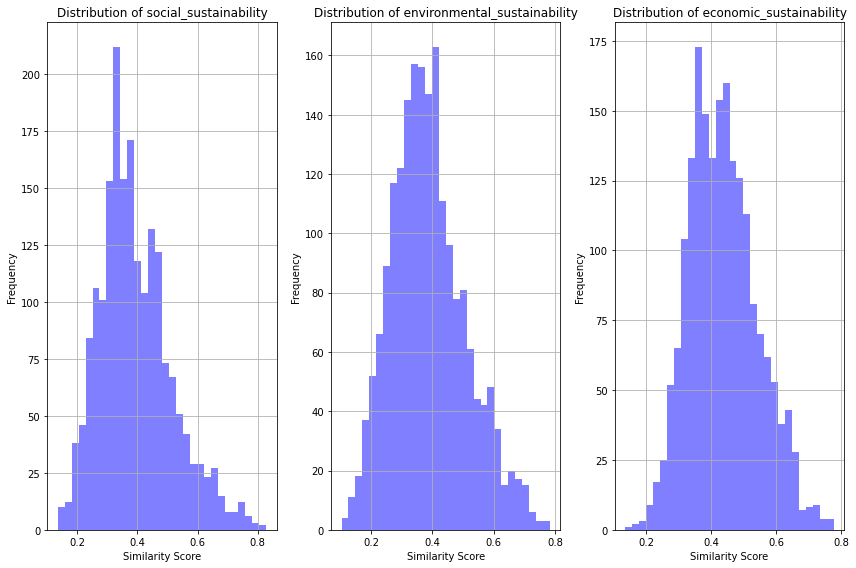

In [18]:
#To visualize the statistics above four plots are generated for the columns
#Function to create a histogram for a given category
def plot_category_histogram(category_similarities, category_name, ax):
    ax.hist(category_similarities, bins=30, alpha=0.5, color='blue')
    ax.set_xlabel('Similarity Score')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of {category_name}')
    ax.grid(True)

#Defining the categories to check
categories = ['social_sustainability', 'environmental_sustainability', 'economic_sustainability']

#Create a 2x2 grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 8))

#Plot histograms for each category
for i, ax in enumerate(axes.flatten()):
    category_similarities = gdelt_df[categories[i]].tolist()
    plot_category_histogram(category_similarities, categories[i], ax)

#Adjust layout and display the plots
plt.tight_layout()
plt.show()

### Apply method and test similarity thresholds
-----------------------------------------
Now that the articles have been embedded and compared using cosine similarity, a similarity threshold will be established for each of the types of sustainability. This threshold will
determine if an article is about the type of sustainablity or not. In the end product this will help in making the decision to display the article to the consumer or not display it at all. 

In order to determine the most swuitable similarity threshold to use per sustainability type the recall, precision and f1-score will be calculated and plotted. When this is done the best scoring
thresholds are identified and applied. 

In [19]:
#Importing libraries needed for methodology testing
from sklearn.metrics import precision_recall_fscore_support #Performance metrics calculation
from ipywidgets import widgets #Create interactive screen for ground truth allocatino
from IPython.display import display, HTML, clear_output #Output text and hyperlink in display
import seaborn as sns #plot the results in a graph

In [20]:
#Create dataframes for two of the leveranciers in order to calculate some metrics for those
#Filter only the articles that have nestle in it
gdelt_nestle = gdelt_df[gdelt_df['producer_in_article'].apply(lambda producers: any("nestle" in producer.lower() or "nestlé" in producer.lower() for producer in producers))].reset_index(drop=True)

#Filter only the articles that have nestle in it
gdelt_mondelez = gdelt_df[gdelt_df['producer_in_article'].apply(lambda producers: any("mondelez" in producer.lower() or "mondelēz" in producer.lower() for producer in producers))].reset_index(drop=True)

#Only take articles that hhave at least one column with a similarity score higher than 0.6
#Check these columns
columns_to_check = ['economic_sustainability', 'social_sustainability', 'environmental_sustainability']
gdelt_nestle = gdelt_nestle[(gdelt_nestle[columns_to_check] > 0.60).any(axis=1)]
gdelt_mondelez = gdelt_mondelez[(gdelt_mondelez[columns_to_check] > 0.60).any(axis=1)]

#Index the dataframes again for use in function to label ground truth
gdelt_nestle.reset_index(drop=True, inplace=True)
gdelt_mondelez.reset_index(drop=True, inplace=True)

In [21]:
#Establishing ground truth for the nestle articles through a display that makes it easier to manually label. Code adapted from ipywidgets (2023)
#Initialize a dictionary to store the ground truth labels for each article
#ground_truth_labels_nestle = {}

#Function to display the article text and label ground truth
#def label_ground_truth(index):
#    article_url = gdelt_nestle.iloc[index]['url']
#    available_topics = ['social', 'economic', 'environmental', 'off_topic']
#    ground_truth = widgets.SelectMultiple(options=available_topics, value=[], description='Ground Truth:')
#    
    #Display the index number of the current article
#    display(HTML(f'<h3>Article Index: {index}</h3>'))
#    
#    #Display the link as a clickable hyperlink so each article can be visited to check
#    display(HTML(f'<a href="{article_url}" target="_blank">{article_url}</a>'))
#    
#    #Display the multi-select widget for ground truth labeling
#    display(ground_truth)
#    
#    #Function to save the selected labels to the dictionary
#    def save_labels(btn):
#        ground_truth_labels_nestle[index] = list(ground_truth.value)
#    
#    #Create a button to save the selected labels
#    save_button = widgets.Button(description="Save Labels")
#    save_button.on_click(save_labels)
#    display(save_button)

#Function to handle the click event of the "Next" button
#def next_article(btn):
#    current_index = next_button.index
#    if current_index < len(gdelt_nestle) - 1:
#        next_index = current_index + 1
#        next_button.index = next_index
#        out.clear_output()
#        #Display the next article for labelling
##        with out:
#            label_ground_truth(next_index)
        

#Create and initialize the index for the "Next" button
#next_button = widgets.Button(description="Next")
#next_button.index = 0
#next_button.on_click(next_article)

#Create an output widget to display the articles
#out = widgets.Output()

#Display the first article for labeling ground truth
#with out:
#    label_ground_truth(next_button.index)
#display(out)
#display(next_button)

In [22]:
#Ground truth topic which has been labelled before to avoid labelling it again
gdelt_nestle_truth = pd.read_csv('gdelt_nestle_truth.csv')

#Process the 'Labels' column to extract and split the labels
gdelt_nestle_truth['Labels'] = gdelt_nestle_truth['Labels'].apply(lambda x: x.split(', '))

#Create a dictionary that maps indices to labels
ground_truth_labels_nestle = dict(zip(gdelt_nestle_truth['Index'], gdelt_nestle_truth['Labels']))

#After the user has labeled all articles, update the 'ground_truth_topic' column in the original DataFrame
gdelt_nestle['ground_truth_topic'] = gdelt_nestle.index.map(lambda index: ground_truth_labels_nestle.get(index, []))
gdelt_nestle.head()

,published,text,title,url,producer_in_article,paragraphs,embeddings_paragraphs,social_sustainability,environmental_sustainability,economic_sustainability,ground_truth_topic
0,2019-08-15 23:00:00,"[Each Friday, we’re republishing an article fr...",Flashback Friday : The Deep Dark Secrets of Ch...,https://hightimes.com/culture/the-deep-dark-se...,"[droste, nestle]",[Each Friday were republishing an article from...,"[[-0.013897804, 0.058974534, -0.0027072937, 0....",0.653466,0.560549,0.624543,[off_topic]
1,2020-03-15 14:30:00,[Lindt & Spruengli AG warned that the premium ...,Lindt CEO issues chocolate price warning on Af...,https://www.ghanaweb.com/GhanaHomePage/busines...,"[mars, nestle]",[Lindt Spruengli AG warned that the premium im...,"[[-0.03363219, -0.034428354, 0.041072834, 0.07...",0.626601,0.636651,0.671440,"[social, economic]"
2,2023-02-16 09:45:00,[Chocolate Liqueur Market Size was valued at $...,Chocolate Liqueur Market Size To Reach USD 6 ....,https://menafn.com/1105576502/Chocolate-Liqueu...,[nestle],[Chocolate Liqueur Market Size was valued at 4...,"[[0.06280595, -0.11238286, 0.02258425, 0.07055...",0.487135,0.510850,0.616618,[off_topic]
3,2023-02-16 10:15:00,"[When you think of Nestlé, you might think of ...","What Vegan at Nestlé ? It Turns Out , Quite A Lot",https://vegnews.com/vegan-recipes/products/veg...,"[nestlé, ferrero]",[When you think of Nestlé you might think of a...,"[[-0.029130833, -0.013828012, 0.052677054, 0.0...",0.634090,0.500413,0.471550,"[social, environmental]"
4,2022-12-16 02:00:00,[Humans have been enjoying chocolate since pre...,The Ultimate Guide to Vegan Chocolate,https://vegnews.com/vegan-guides/chocolate/ult...,"[mars, nestlé]",[Humans have been enjoying chocolate since pre...,"[[0.014660723, 0.032108784, 0.023261094, 0.089...",0.789647,0.536258,0.552691,"[social, economic]"


In [23]:
#Establishing ground truth for the mondelez articles
#Initialize a dictionary to store the ground truth labels for each article
#ground_truth_labels_mondelez = {}

#Function to display the article text and label ground truth
#def label_ground_truth(index):
#    article_url = gdelt_mondelez.iloc[index]['url']
#    available_topics = ['social', 'economic', 'environmental', 'off_topic']
#    ground_truth = widgets.SelectMultiple(options=available_topics, value=[], description='Ground Truth:')
#    
##    #Display the index number of the current article
#    display(HTML(f'<h3>Article Index: {index}</h3>'))
#    
    #Display the link as a clickable hyperlink so each article can be visited to check
#    display(HTML(f'<a href="{article_url}" target="_blank">{article_url}</a>'))
    
#    #Display the multi-select widget for ground truth labeling
#    display(ground_truth)
#    
##    #Function to save the selected labels to the dictionary
#    def save_labels(btn):
##        ground_truth_labels_mondelez[index] = list(ground_truth.value)
#    
#    #Create a button to save the selected labels
#    save_button = widgets.Button(description="Save Labels")
#    save_button.on_click(save_labels)
#    display(save_button)

#Function to handle the click event of the "Next" button
#def next_article(btn):
#    current_index = next_button.index
#    if current_index < len(gdelt_mondelez) - 1:
#        next_index = current_index + 1
#        next_button.index = next_index
#        out.clear_output()
#        #Display the next article for labelling
#        with out:
#            label_ground_truth(next_index)
        

#Create and initialize the index for the "Next" button
#next_button = widgets.Button(description="Next")
#next_button.index = 0
#next_button.on_click(next_article)

#Create an output widget to display the articles
#out = widgets.Output()

#Display the first article for labeling ground truth
#with out:
##    label_ground_truth(next_button.index)
#display(out)
#display(next_button)

In [24]:
#Ground truth topic which has been labelled before to avoid labelling it again
gdelt_mondelez_truth = pd.read_csv('gdelt_mondelez_truth.csv')

#Process the 'Labels' column to extract and split the labels
gdelt_mondelez_truth['Labels'] = gdelt_mondelez_truth['Labels'].apply(lambda x: x.split(', '))

#Create a dictionary that maps indices to labels
ground_truth_labels_mondelez = dict(zip(gdelt_mondelez_truth['Index'], gdelt_mondelez_truth['Labels']))

#After the user has labeled all articles, update the 'ground_truth_topic' column in the original DataFrame
gdelt_mondelez['ground_truth_topic'] = gdelt_mondelez.index.map(lambda index: ground_truth_labels_mondelez.get(index, []))
gdelt_mondelez.head()

,published,text,title,url,producer_in_article,paragraphs,embeddings_paragraphs,social_sustainability,environmental_sustainability,economic_sustainability,ground_truth_topic
0,2020-06-15 08:30:00,[New York/Chicago:. When commodity analyst Jud...,A global chocolate glut is coming because duty...,https://theprint.in/economy/a-global-chocolate...,[mondelez],[New YorkChicago. When commodity analyst Judy ...,"[[0.037676096, -0.009614286, -0.030734621, 0.0...",0.627726,0.583250,0.632643,[economic]
1,2020-06-15 10:30:00,"[In the four airports she passed through, Ms. ...",Darkened duty - free shops are fueling a world...,https://www.bworldonline.com/darkened-duty-fre...,[mondelez],[In the four airports she passed through Ms. G...,"[[0.065963805, -0.014027047, 0.043266714, 0.05...",0.627726,0.583250,0.632643,[economic]
2,2021-05-16 03:15:00,"[Newark, NJ, May 24, 2021 (GLOBE NEWSWIRE) -- ...",Global Candy Market Is Expected to Reach USD 2...,https://www.globenewswire.com/news-release/202...,"[august storck, cloetta, mars, mondelēz, nestl...",[Newark NJ May 24 2021 GLOBE NEWSWIRE As per t...,"[[-0.027374152, -0.04465185, 0.010075209, 0.04...",0.471651,0.395542,0.607830,[off_topic]
3,2021-05-16 03:30:00,"[Newark, NJ, May 24, 2021 (GLOBE NEWSWIRE) -- ...",Global Candy Market Is Expected to Reach USD 2...,https://www.benzinga.com/pressreleases/21/05/g...,"[august storck, cloetta, mars, mondelēz, nestl...",[Newark NJ May 24 2021 GLOBE NEWSWIRE As per t...,"[[-0.027374152, -0.04465185, 0.010075209, 0.04...",0.471651,0.395542,0.607830,[off_topic]
4,2022-06-16 17:45:00,[The Swiss chocolate maker Barry Callebaut has...,Salmonella Outbreak Shuts Down World Largest ...,https://www.theepochtimes.com/salmonella-outbr...,"[mondelez, nestle, ferrero]",[The Swiss chocolate maker Barry Callebaut has...,"[[-0.021309474, -0.066940784, 0.003855342, 0.0...",0.608259,0.464295,0.522583,[off_topic]


In [25]:
#Generate grount truth columns for nestle per topic
#List of possible topics
possible_topics = ['off_topic', 'social', 'economic', 'environmental']

#Create binary columns for each topic for nestle
for topic in possible_topics:
    gdelt_nestle[f'{topic}_truth'] = gdelt_nestle['ground_truth_topic'].apply(lambda x: 1 if topic in x else 0)

#Check if binary columns are present now
gdelt_nestle.head()

,published,text,title,url,producer_in_article,paragraphs,embeddings_paragraphs,social_sustainability,environmental_sustainability,economic_sustainability,ground_truth_topic,off_topic_truth,social_truth,economic_truth,environmental_truth
0,2019-08-15 23:00:00,"[Each Friday, we’re republishing an article fr...",Flashback Friday : The Deep Dark Secrets of Ch...,https://hightimes.com/culture/the-deep-dark-se...,"[droste, nestle]",[Each Friday were republishing an article from...,"[[-0.013897804, 0.058974534, -0.0027072937, 0....",0.653466,0.560549,0.624543,[off_topic],1,0,0,0
1,2020-03-15 14:30:00,[Lindt & Spruengli AG warned that the premium ...,Lindt CEO issues chocolate price warning on Af...,https://www.ghanaweb.com/GhanaHomePage/busines...,"[mars, nestle]",[Lindt Spruengli AG warned that the premium im...,"[[-0.03363219, -0.034428354, 0.041072834, 0.07...",0.626601,0.636651,0.671440,"[social, economic]",0,1,1,0
2,2023-02-16 09:45:00,[Chocolate Liqueur Market Size was valued at $...,Chocolate Liqueur Market Size To Reach USD 6 ....,https://menafn.com/1105576502/Chocolate-Liqueu...,[nestle],[Chocolate Liqueur Market Size was valued at 4...,"[[0.06280595, -0.11238286, 0.02258425, 0.07055...",0.487135,0.510850,0.616618,[off_topic],1,0,0,0
3,2023-02-16 10:15:00,"[When you think of Nestlé, you might think of ...","What Vegan at Nestlé ? It Turns Out , Quite A Lot",https://vegnews.com/vegan-recipes/products/veg...,"[nestlé, ferrero]",[When you think of Nestlé you might think of a...,"[[-0.029130833, -0.013828012, 0.052677054, 0.0...",0.634090,0.500413,0.471550,"[social, environmental]",0,1,0,1
4,2022-12-16 02:00:00,[Humans have been enjoying chocolate since pre...,The Ultimate Guide to Vegan Chocolate,https://vegnews.com/vegan-guides/chocolate/ult...,"[mars, nestlé]",[Humans have been enjoying chocolate since pre...,"[[0.014660723, 0.032108784, 0.023261094, 0.089...",0.789647,0.536258,0.552691,"[social, economic]",0,1,1,0


In [26]:
#Generate ground truth columns for mondelez per topic
#Create binary columns for each topic for mondelez
for topic in possible_topics:
    gdelt_mondelez[f'{topic}_truth'] = gdelt_mondelez['ground_truth_topic'].apply(lambda x: 1 if topic in x else 0)

#Check if binary columns are present now
gdelt_mondelez.head()

,published,text,title,url,producer_in_article,paragraphs,embeddings_paragraphs,social_sustainability,environmental_sustainability,economic_sustainability,ground_truth_topic,off_topic_truth,social_truth,economic_truth,environmental_truth
0,2020-06-15 08:30:00,[New York/Chicago:. When commodity analyst Jud...,A global chocolate glut is coming because duty...,https://theprint.in/economy/a-global-chocolate...,[mondelez],[New YorkChicago. When commodity analyst Judy ...,"[[0.037676096, -0.009614286, -0.030734621, 0.0...",0.627726,0.583250,0.632643,[economic],0,0,1,0
1,2020-06-15 10:30:00,"[In the four airports she passed through, Ms. ...",Darkened duty - free shops are fueling a world...,https://www.bworldonline.com/darkened-duty-fre...,[mondelez],[In the four airports she passed through Ms. G...,"[[0.065963805, -0.014027047, 0.043266714, 0.05...",0.627726,0.583250,0.632643,[economic],0,0,1,0
2,2021-05-16 03:15:00,"[Newark, NJ, May 24, 2021 (GLOBE NEWSWIRE) -- ...",Global Candy Market Is Expected to Reach USD 2...,https://www.globenewswire.com/news-release/202...,"[august storck, cloetta, mars, mondelēz, nestl...",[Newark NJ May 24 2021 GLOBE NEWSWIRE As per t...,"[[-0.027374152, -0.04465185, 0.010075209, 0.04...",0.471651,0.395542,0.607830,[off_topic],1,0,0,0
3,2021-05-16 03:30:00,"[Newark, NJ, May 24, 2021 (GLOBE NEWSWIRE) -- ...",Global Candy Market Is Expected to Reach USD 2...,https://www.benzinga.com/pressreleases/21/05/g...,"[august storck, cloetta, mars, mondelēz, nestl...",[Newark NJ May 24 2021 GLOBE NEWSWIRE As per t...,"[[-0.027374152, -0.04465185, 0.010075209, 0.04...",0.471651,0.395542,0.607830,[off_topic],1,0,0,0
4,2022-06-16 17:45:00,[The Swiss chocolate maker Barry Callebaut has...,Salmonella Outbreak Shuts Down World Largest ...,https://www.theepochtimes.com/salmonella-outbr...,"[mondelez, nestle, ferrero]",[The Swiss chocolate maker Barry Callebaut has...,"[[-0.021309474, -0.066940784, 0.003855342, 0.0...",0.608259,0.464295,0.522583,[off_topic],1,0,0,0


### Nestle
Now the necessary columns have been created it is possible to iterate over different similarity thresholds to find the best ones for each topic for articles containing Nestle.<br>
The following has been done:<br>
- Calculating precision, recall, and f1 score for every topic on every similarity threshold<br>
- Saving it in a dataframe<br>
- Plotting the results for nestle<br>

-----------------------------------

In [27]:
#Define the list of similarity thresholds to test
similarity_thresholds = [0.6, 0.65, 0.70, 0.75]

#List of topics to be looked at
topics = ['social', 'economic', 'environmental', 'off_topic']

#Creating a new df for results
results_nestle = []

#Loop through similarity thresholds and topics
for score in similarity_thresholds:
    gdelt_nestle['off_topic_sustainability'] = gdelt_nestle.apply(lambda row: 1 if all(row[col] < score for col in ['social_sustainability', 'environmental_sustainability', 'economic_sustainability']) else 0, axis=1)
    for topic in topics:
        y_true = gdelt_nestle[f'{topic}_truth']
        y_pred = gdelt_nestle[f'{topic}_sustainability'] >= score
        
        #If none of the sustainability scores reaches the threshold, compare with 'off_topic_truth'
        if all(gdelt_nestle[f'{topic}_sustainability'] < score):
            y_true = gdelt_nestle['off_topic_truth']
            y_pred = gdelt_nestle['off_topic_sustainability']
        
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
        results_nestle.append({'Similarity Threshold': score, 'Topic': topic, 'Precision': precision, 'Recall': recall, 'F1-Score': f1})

#Create a DataFrame from results
results_nestle_df = pd.DataFrame(results_nestle)

#Check the results
print(results_nestle_df)

    Similarity Threshold          Topic  Precision    Recall  F1-Score
0                   0.60         social   0.730769  1.000000  0.844444
1                   0.60       economic   0.531915  0.757576  0.625000
2                   0.60  environmental   0.800000  0.823529  0.811594
3                   0.60      off_topic   0.000000  0.000000  0.000000
4                   0.65         social   0.764706  0.684211  0.722222
5                   0.65       economic   0.909091  0.606061  0.727273
6                   0.65  environmental   0.896552  0.764706  0.825397
7                   0.65      off_topic   0.760000  0.703704  0.730769
8                   0.70         social   1.000000  0.473684  0.642857
9                   0.70       economic   0.777778  0.212121  0.333333
10                  0.70  environmental   0.875000  0.411765  0.560000
11                  0.70      off_topic   0.590909  0.962963  0.732394
12                  0.75         social   1.000000  0.421053  0.592593
13    

c:\Users\ghuiskens\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


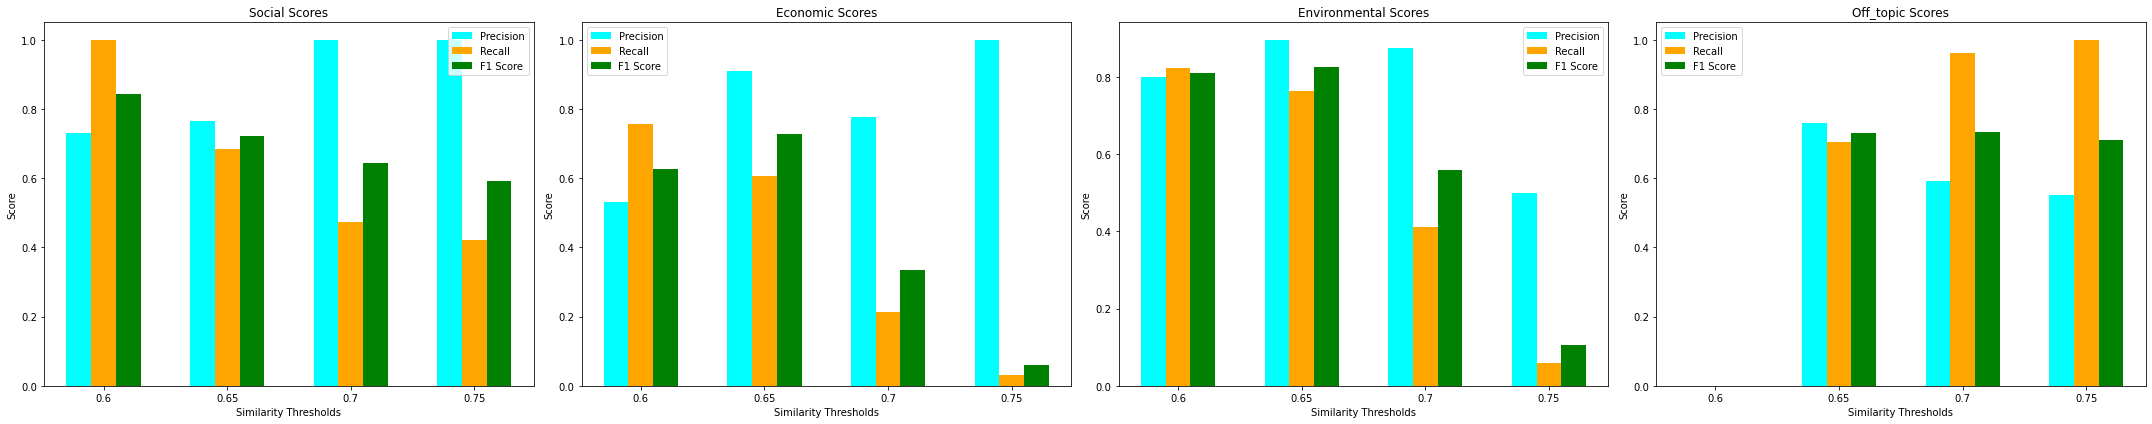

In [28]:
#List of unique topics
topics = results_nestle_df['Topic'].unique()

#Create a figure with subplots
fig, axes = plt.subplots(1,4, figsize=(30, 6))

#Plot each topic separately in its respective subplot
for idx, topic in enumerate(topics):
    topic_data = results_nestle_df[results_nestle_df['Topic'] == topic]
    x = np.arange(len(topic_data))
    width = 0.2

    axes[idx].bar(x - width, topic_data['Precision'], width, label='Precision', color='cyan')
    axes[idx].bar(x, topic_data['Recall'], width, label='Recall', color='orange')
    axes[idx].bar(x + width, topic_data['F1-Score'], width, label='F1 Score', color='green')

    axes[idx].set_xlabel("Similarity Thresholds")
    axes[idx].set_ylabel("Score")
    axes[idx].set_title(f"{topic.capitalize()} Scores")
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(topic_data['Similarity Threshold'])
    axes[idx].legend()

#Plot the graphs
plt.tight_layout()
plt.show()

### Mondelez
Now the necessary columns have been created it is possible to iterate over different similarity thresholds to find the best ones for each topic for articles containing Mondelez.<br>
The following has been done:<br>
-Calculating precision, recall, and f1 score for every topic on every similarity threshold<br>
-Saving it in a dataframe<br>
-Plotting the results for Mondelez<br>
_________________________________________________

In [29]:
#Define the list of similarity thresholds to test
similarity_thresholds = [0.6, 0.65, 0.70, 0.75]

#List of topics to be looked at
topics = ['social', 'economic', 'environmental', 'off_topic']

#Creating a new df for results
results_mondelez = []

#Loop through similarity thresholds and topics
for score in similarity_thresholds:
    #Define off topic sustianability so it can be compared as well
    gdelt_mondelez['off_topic_sustainability'] = gdelt_mondelez.apply(lambda row: 1 if all(row[col] < score for col in ['social_sustainability', 'environmental_sustainability', 'economic_sustainability']) else 0, axis=1)
    for topic in topics:
        y_true = gdelt_mondelez[f'{topic}_truth']
        y_pred = gdelt_mondelez[f'{topic}_sustainability'] >= score
        
        #If none of the sustainability scores reaches the threshold, compare with 'off_topic_truth'
        if all(gdelt_mondelez[f'{topic}_sustainability'] < score):
            y_true = gdelt_mondelez['off_topic_truth']
            y_pred = gdelt_mondelez['off_topic_sustainability']
        
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
        results_mondelez.append({'Similarity Threshold': score, 'Topic': topic, 'Precision': precision, 'Recall': recall, 'F1-Score': f1})

#Create a DataFrame from results
results_mondelez_df = pd.DataFrame(results_mondelez)

#Check the results
print(results_mondelez_df)

    Similarity Threshold          Topic  Precision    Recall  F1-Score
0                   0.60         social   0.692308  1.000000  0.818182
1                   0.60       economic   0.823529  0.933333  0.875000
2                   0.60  environmental   0.947368  1.000000  0.972973
3                   0.60      off_topic   0.000000  0.000000  0.000000
4                   0.65         social   0.705882  0.666667  0.685714
5                   0.65       economic   0.900000  0.600000  0.720000
6                   0.65  environmental   1.000000  0.888889  0.941176
7                   0.65      off_topic   0.500000  0.428571  0.461538
8                   0.70         social   1.000000  0.388889  0.560000
9                   0.70       economic   0.857143  0.400000  0.545455
10                  0.70  environmental   1.000000  0.555556  0.714286
11                  0.70      off_topic   0.466667  1.000000  0.636364
12                  0.75         social   1.000000  0.277778  0.434783
13    

c:\Users\ghuiskens\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


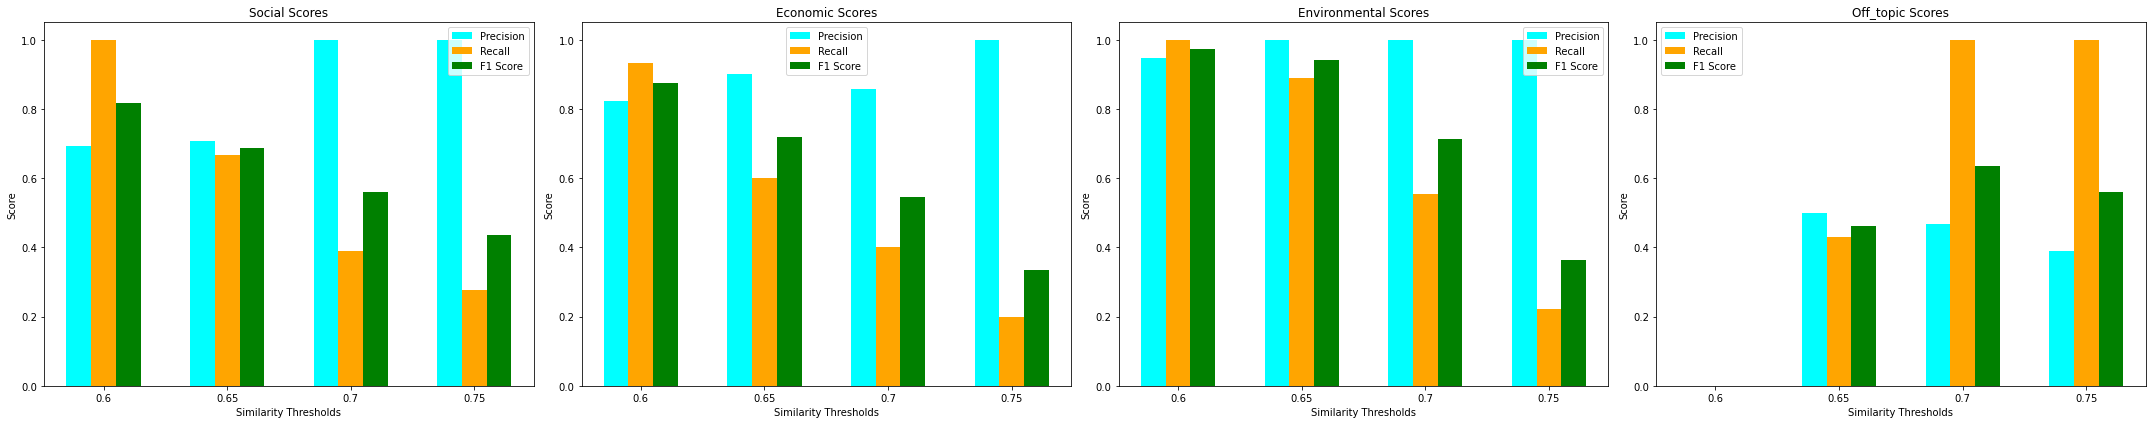

In [30]:
#Plot graphs to visualize the metric results
#List of unique topics
topics = results_mondelez_df['Topic'].unique()

#Create a figure with subplots
fig, axes = plt.subplots(1,4, figsize=(30, 6))

#Plot each topic separately in its respective subplot
for idx, topic in enumerate(topics):
    topic_data = results_mondelez_df[results_mondelez_df['Topic'] == topic]
    x = np.arange(len(topic_data))
    width = 0.2

    axes[idx].bar(x - width, topic_data['Precision'], width, label='Precision', color='cyan')
    axes[idx].bar(x, topic_data['Recall'], width, label='Recall', color='orange')
    axes[idx].bar(x + width, topic_data['F1-Score'], width, label='F1 Score', color='green')

    axes[idx].set_xlabel("Similarity Thresholds")
    axes[idx].set_ylabel("Score")
    axes[idx].set_title(f"{topic.capitalize()} Scores")
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(topic_data['Similarity Threshold'])
    axes[idx].legend()

#Plot the graphs
plt.tight_layout()
plt.show()

### Evaluation of total test set
_______________________________________________________________

In [31]:
#To check the average of the data tested (both mondelez and nestle together) a new dataframe is created with all results
#Create a new dataframe for the total
total_test_df = pd.concat([gdelt_mondelez, gdelt_nestle], ignore_index=True)


#Define the list of similarity thresholds to test
similarity_thresholds = [0.6, 0.65, 0.70, 0.75]

#List of topics to be looked at
topics = ['social', 'economic', 'environmental', 'off_topic']

#Creating a new df for results
results_total = []

#Loop through similarity thresholds and topics
for score in similarity_thresholds:
    #Define off topic sustianability so it can be compared as well
    total_test_df['off_topic_sustainability'] = total_test_df.apply(lambda row: 1 if all(row[col] < score for col in ['social_sustainability', 'environmental_sustainability', 'economic_sustainability']) else 0, axis=1)
    for topic in topics:
        y_true = total_test_df[f'{topic}_truth']
        y_pred = total_test_df[f'{topic}_sustainability'] >= score
        
        #If none of the sustainability scores reaches the threshold, compare with 'off_topic_truth'
        if all(total_test_df[f'{topic}_sustainability'] < score):
            y_true = total_test_df['off_topic_truth']
            y_pred = total_test_df['off_topic_sustainability']
        
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
        results_total.append({'Similarity Threshold': score, 'Topic': topic, 'Precision': precision, 'Recall': recall, 'F1-Score': f1})

#Create a DataFrame from results
results_total_df = pd.DataFrame(results_total)

#Check the results
print(results_total_df)

    Similarity Threshold          Topic  Precision    Recall  F1-Score
0                   0.60         social   0.717949  1.000000  0.835821
1                   0.60       economic   0.609375  0.812500  0.696429
2                   0.60  environmental   0.851852  0.884615  0.867925
3                   0.60      off_topic   0.000000  0.000000  0.000000
4                   0.65         social   0.745098  0.678571  0.710280
5                   0.65       economic   0.906250  0.604167  0.725000
6                   0.65  environmental   0.933333  0.807692  0.865979
7                   0.65      off_topic   0.709677  0.647059  0.676923
8                   0.70         social   1.000000  0.446429  0.617284
9                   0.70       economic   0.812500  0.270833  0.406250
10                  0.70  environmental   0.923077  0.461538  0.615385
11                  0.70      off_topic   0.559322  0.970588  0.709677
12                  0.75         social   1.000000  0.375000  0.545455
13    

c:\Users\ghuiskens\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


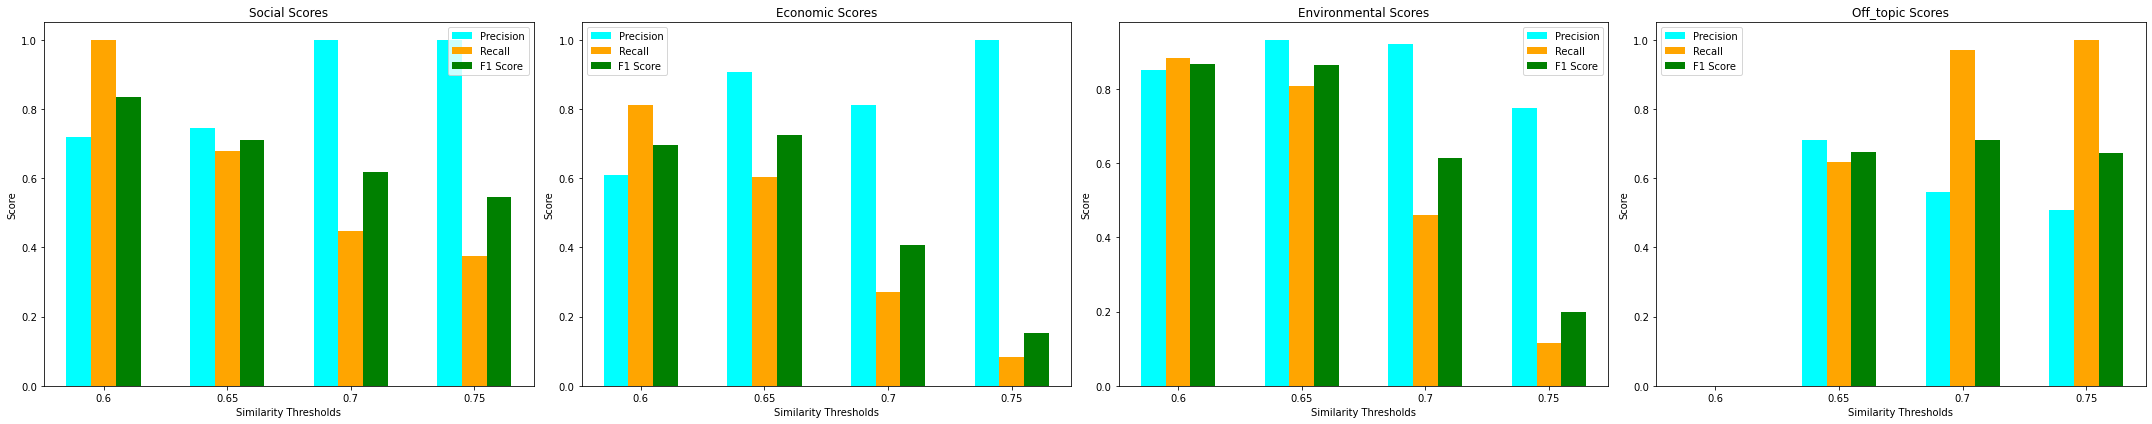

In [32]:
#Create a plot of the two test dataframes combined which will allow to see the best performing similarity threshold for each topic
#List of unique topics
topics = results_total_df['Topic'].unique()

#Create a figure with subplots
fig, axes = plt.subplots(1,4, figsize=(30, 6))

#Plot each topic separately in its respective subplot
for idx, topic in enumerate(topics):
    topic_data = results_total_df[results_total_df['Topic'] == topic]
    x = np.arange(len(topic_data))
    width = 0.2

    axes[idx].bar(x - width, topic_data['Precision'], width, label='Precision', color='cyan')
    axes[idx].bar(x, topic_data['Recall'], width, label='Recall', color='orange')
    axes[idx].bar(x + width, topic_data['F1-Score'], width, label='F1 Score', color='green')

    axes[idx].set_xlabel("Similarity Thresholds")
    axes[idx].set_ylabel("Score")
    axes[idx].set_title(f"{topic.capitalize()} Scores")
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(topic_data['Similarity Threshold'])
    axes[idx].legend()

#Plot the graphs
plt.tight_layout()
plt.show()

In [33]:
#Create a new dataframe for the total
total_average_df = pd.concat([gdelt_mondelez, gdelt_nestle], ignore_index=True)

#Define the list of similarity thresholds to test
similarity_thresholds = [0.6, 0.65, 0.70, 0.75]

#List of topics to be looked at
topics = ['social', 'economic', 'environmental', 'off_topic']

#Creating a new df for results
results_average = []

#Loop through similarity thresholds
for score in similarity_thresholds:
    total_tp, total_fp, total_fn = 0, 0, 0
    for topic in topics:
        y_true = total_average_df[f'{topic}_truth']
        y_pred = total_average_df[f'{topic}_sustainability'] >= score
        
        #If none of the sustainability scores reaches the threshold, compare with 'off_topic_truth'
        if all(total_test_df[f'{topic}_sustainability'] < score):
            y_true = total_average_df['off_topic_truth']
            y_pred = total_average_df['off_topic_sustainability']
        
        tp, fp, fn, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
        total_tp += tp
        total_fp += fp
        total_fn += fn

    precision = total_tp / (total_tp + total_fp)
    recall = total_tp / (total_tp + total_fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    results_average.append({'Similarity Threshold': score, 'Precision': precision, 'Recall': recall, 'F1-Score': f1})

#Create a DataFrame from results
results_average_df = pd.DataFrame(results_average)

#Check the results
print(results_average_df)

   Similarity Threshold  Precision    Recall  F1-Score
0                  0.60   0.420856  0.466424  0.442470
1                  0.65   0.500139  0.509694  0.504871
2                  0.70   0.598144  0.583782  0.590876
3                  0.75   0.674258  0.674419  0.674338


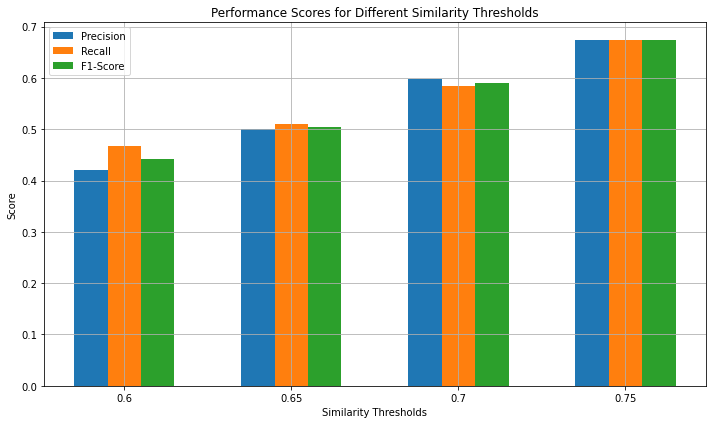

In [34]:
#Plot again but for one plot as to find the best performing similarity threshold in general
#Create a plot of the two test dataframes combined which will allow to see the best performing similarity threshold for each topic
plt.figure(figsize=(10, 6))

#Define bar width and offset
bar_width = 0.2
offsets = np.arange(len(results_average_df['Similarity Threshold']))

#Plot grouped bars for each metric and similarity threshold
for idx, metric in enumerate(['Precision', 'Recall', 'F1-Score']):
    plt.bar(offsets + idx * bar_width, results_average_df[metric], width=bar_width, label=metric)

#Configure the x-axis and labels
plt.xlabel("Similarity Thresholds")
plt.ylabel("Score")
plt.title("Performance Scores for Different Similarity Thresholds")
plt.xticks(offsets + bar_width, results_average_df['Similarity Threshold'])
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

However, it is important to also take into account the number of articles that are included. Below is a graph with the all similarity scores for each article and all topics put together. This is from a total of 1958 articles, each with three similarity scores, so a total of 5874 scores. Looking at the graph this means that only about 50-70 articles have a similarity score high enough to label them correctly for the lowest threshold of 0,6. 

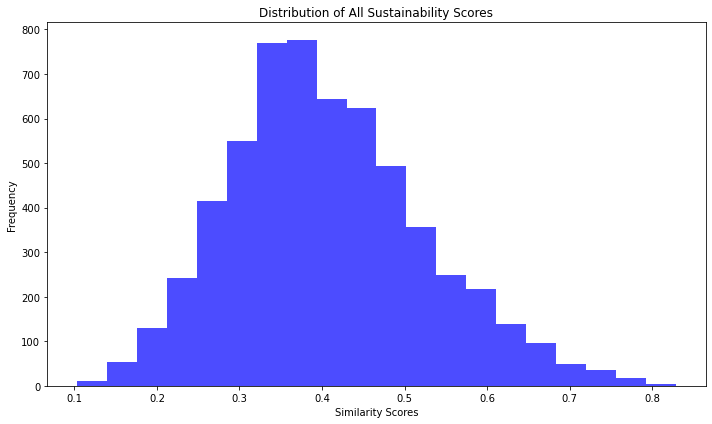

In [35]:
#Defining a plot to look at the distribution of scores, to get an insight in how threshold influence articles that could be labelled as a certain topic. 
#Create a figure
plt.figure(figsize=(10, 6))

#Concatenate all sustainability scores into a single array so that we can create one overview
all_scores = gdelt_df[['social_sustainability', 'economic_sustainability', 'environmental_sustainability']].values.flatten()

#Plot the histogram
plt.hist(all_scores, bins=20, color='blue', alpha=0.7)
plt.xlabel("Similarity Scores")
plt.ylabel("Frequency")
plt.title("Distribution of All Sustainability Scores")
plt.tight_layout()
plt.show()

### Conclusion

For this relatively small dataset of 1958 articles it is important not to lose the majority of the data. The similarity threshold of 0.65 will be used for the display of articles, making sure that there is a relatively okay number of articles and there is a relative certainty of classifying the correct topic. This is a first run there is room for improvement, as will be discussed in the limiations of this project.

The dataframe gdelt_df will be used as input for the recommender system with the columns:
- Published
- Title
- Producer_in_article
- Article text
- Article URL
- Social similarity
- Environmental similarity
- Economic similarity

In [36]:
#To create the final dataframe we needc to drop two columns
#List of columns to drop
columns_to_drop = ['paragraphs', 'embeddings_paragraphs']

#Drop the specified columns and create the final dataframe in a new variable name
gdelt_classification_input_recommender = gdelt_df.copy()
gdelt_classification_input_recommender.drop(columns=columns_to_drop, inplace=True)
gdelt_classification_input_recommender.head(1)

,published,text,title,url,producer_in_article,social_sustainability,environmental_sustainability,economic_sustainability
0,2022-03-15 05:45:00,[These ancient creatures can squeeze through t...,Progressive Charlestown,http://www.progressive-charlestown.com/search?...,[copar],0.379858,0.420189,0.487699


In [37]:
#Specify the path where the pickle file will be saved
recommender_pickle_file_path = r'C:\Users\ghuiskens\Thesis\News analysis\news classification\gdelt_classification_input_recommender.pkl'

#Serialize the entire DataFrame using pickle
def serialize_dataframe(dataframe):
    return pickle.dumps(dataframe, protocol=pickle.HIGHEST_PROTOCOL)

recommender_serialized_df = serialize_dataframe(gdelt_classification_input_recommender)

#Save the serialized DataFrame to a pickle file
with open(recommender_pickle_file_path, 'wb') as f:
    f.write(recommender_serialized_df)

print("Pickle file saved successfully.")

Pickle file saved successfully.


### Bibliography
1) SBERT. (n.d.). Sentence-BERT: Sentence Embeddings using Siamese BERT. SBERT. https://www.sbert.net/. Retrieved August 17, 2023.
2) IPython Project. (n.d.). Widget Basics. IPython Widgets Documentation. https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Basics.html. Retrieved August 17, 2023.